In [3]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 14.3

In [42]:
n = 4
A_tot = 10000
alpha = np.array([1e-5, 1e-2, 1e-2, 1e-2])
M = np.array([0.1, 5, 10, 10])
A_max = np.array([40, 40, 40, 20])

In [43]:
a = cp.Variable(n, pos = True)
t = cp.Variable(pos = True)
Nout_2 = cp.sum([alpha[i]**2*cp.prod(a[i:n])**2 for i in range(n)])

obj = cp.Minimize(t)

constraints =   [cp.prod(a) == A_tot] + \
                [Nout_2 <= t*M[i]**2*cp.prod(a[i+1:])**2 for i in range(n)] + \
                [a[i] <= A_max[i] for i in range(n)]    

problem = cp.Problem(obj, constraints)
problem.solve(gp = True)




np.float64(0.06264006258467303)

In [46]:


print("Optimal gains:", a.value)
print("Optimal dynamic range:", np.sqrt(1/t.value))

Optimal gains: [39.99999999 39.99999756  6.24987009  1.00002085]
Optimal dynamic range: 3.9955255163804715


## 17.4

In [7]:


x = np.array([0.1, 0.2, -0.05, 0.1])
n = len(x)
sigma_diag = np.array([0.2, 0.1, 0.3, 0.1])
Sigma_wc = cp.Variable((n, n), PSD = True)

constraints = [
    Sigma_wc[0, 1] >= 0, 
    Sigma_wc[0, 2] >= 0,  
    Sigma_wc[1, 2] <= 0,  
    Sigma_wc[1, 3] <= 0,  
    Sigma_wc[2, 3] >= 0
]

for i in range(n):
    constraints.append(Sigma_wc[i, i] == sigma_diag[i])

variance_wc = cp.quad_form(x, Sigma_wc)
objective = cp.Maximize(variance_wc)

problem = cp.Problem(objective, constraints)
problem.solve()


np.float64(0.015166101233105826)

In [8]:


sigma_wc_value = problem.value
Sigma_wc_value = Sigma_wc.value
sigma_diag_value = x.T @ np.diag(sigma_diag) @ x


In [9]:
print("The worst case risk is given by :", sigma_wc_value,"\n The worst case risk obtained when Sigma is diagonal is given by :" ,sigma_diag_value, "\n The assciated covariance matrix is given by ", Sigma_wc_value)

The worst case risk is given by : 0.015166101233105826 
 The worst case risk obtained when Sigma is diagonal is given by : 0.007750000000000002 
 The assciated covariance matrix is given by  [[ 2.00000000e-01  9.33324323e-02  9.31686604e-07  8.30130856e-02]
 [ 9.33324323e-02  1.00000000e-01 -1.09983027e-01 -6.03504496e-07]
 [ 9.31686604e-07 -1.09983027e-01  3.00000000e-01  1.77084868e-02]
 [ 8.30130856e-02 -6.03504496e-07  1.77084868e-02  9.99999995e-02]]


In [10]:

df = pd.DataFrame(Sigma_wc_value, columns=["Asset 1", "Asset 2", "Asset 3", "Asset 4"], index=["Asset 1", "Asset 2", "Asset 3", "Asset 4"])
df


,Asset 1,Asset 2,Asset 3,Asset 4
Asset 1,2.000000e-01,9.333243e-02,9.316866e-07,8.301309e-02
Asset 2,9.333243e-02,1.000000e-01,-1.099830e-01,-6.035045e-07
Asset 3,9.316866e-07,-1.099830e-01,3.000000e-01,1.770849e-02
Asset 4,8.301309e-02,-6.035045e-07,1.770849e-02,1.000000e-01


## 17.16

In [11]:
r = 1.05 
S0 = 1  
m = 200 
S = np.linspace(0.5, 2, m)
strike_prices = np.array([1.1, 1.2, 0.8, 0.7])
market_prices = np.array([1, 1, 0.06, 0.03, 0.02, 0.01])
option_types = ["call", "call", "put", "put"]
F = 0.9  
C = 1.15   

In [12]:
def put_payoff(K, S):
    return np.maximum(K - S, 0)

def call_payoff(K, S):
    return np.maximum(S - K, 0)

def collar_payoff(S, F, C):
    return np.minimum(C, np.maximum(F, S))


In [13]:
payoff_matrix = np.vstack([
    np.full(m, r), 
    S, 
    *[call_payoff(strike, S) if opt_type == "call" else put_payoff(strike, S) 
      for strike, opt_type in zip(strike_prices, option_types)],
    collar_payoff(S, F, C)
])

In [14]:
y = cp.Variable(m, pos=True)
asset_prices = cp.Variable(7)

pricing_constraints = [
    payoff_matrix @ y == asset_prices,
    *[asset_prices[i] == market_prices[i] for i in range(6)]
]

In [15]:
collar_bounds = [
    cp.Problem(cp.Minimize(asset_prices[6]), pricing_constraints),
    cp.Problem(cp.Maximize(asset_prices[6]), pricing_constraints)
]


for problem in collar_bounds:
    problem.solve()

print(f"Collar price range: [{collar_bounds[0].value:.4f}, {collar_bounds[1].value:.4f}]")


Collar price range: [0.9850, 1.0173]


## 18.7

In [16]:

n = 100 
d = 1 

e = 5 * np.sin(np.arange(1, n + 1) / n * 3 * np.pi) + np.sin(
    np.arange(1, n + 1) / n * 10 * np.pi
)

D1 = 0.08 
D2 = 0.025  
D3 = 0.005 

alpha_fill = 2
beta_fill = 30
alpha_cut = 12
beta_cut = 1


h = cp.Variable(n)

fill_cost = alpha_fill * cp.square(cp.pos(h - e)) + beta_fill * cp.pos(h - e)
cut_cost = alpha_cut * cp.square(cp.pos(e - h)) + beta_cut * cp.pos(e - h)
cost = cp.sum(fill_cost + cut_cost)


In [17]:

constraints = []
for i in range(n - 1):
    constraints.append(cp.abs(h[i + 1] - h[i]) / d <= D1)
for i in range(1, n - 1):
    constraints.append(cp.abs(h[i + 1] - 2 * h[i] + h[i - 1]) / d**2 <= D2)
for i in range(2, n - 1):
    constraints.append(cp.abs(h[i + 1] - 3 * h[i] + 3 * h[i - 1] - h[i - 2]) / d**3 <= D3)


problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()



/Users/noemieclaret/Library/Python/3.9/lib/python/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


np.float64(7562.471218690049)

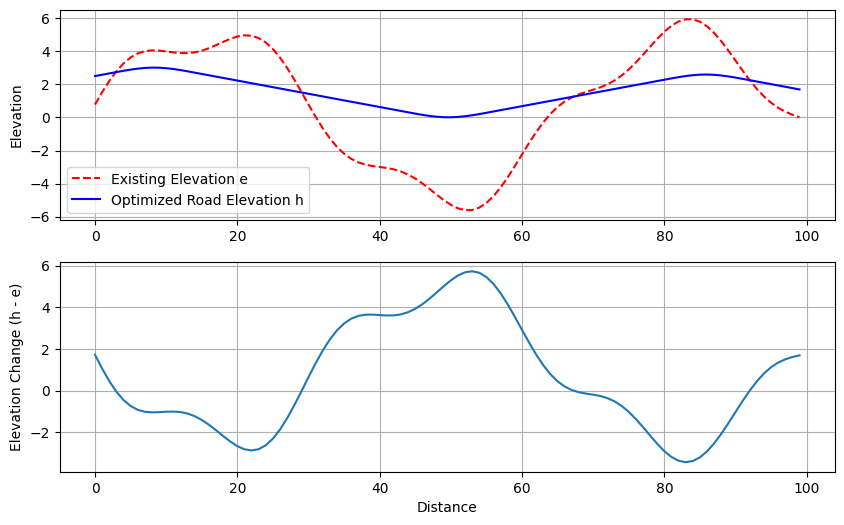

In [18]:

h_opt = h.value

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(n) * d, e, "--r", label="Existing Elevation e")
plt.plot(np.arange(n) * d, h_opt, "b", label="Optimized Road Elevation h")
plt.ylabel("Elevation")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(np.arange(n) * d, h_opt - e)
plt.ylabel("Elevation Change (h - e)")
plt.xlabel("Distance")
plt.grid()

plt.show()

## 20.13

a)

In [47]:
PLOT_FIGURES = False  # True to plot figures, false to suppress plots

N = 96  # Number of periods in the day (so each interval 15 minutes)

# Convenience variables for plotting
fig_size = (14, 3)
xtick_vals = [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]
xtick_labels = (
    "0:00",
    "2:00am",
    "4:00am",
    "5:00am",
    "8:00am",
    "10:00am",
    "12:00pm",
    "2:00pm",
    "4:00pm",
    "6:00pm",
    "8:00pm",
    "10:00pm",
    "12:00am",
)

#############################################
# Price data generation - price values and intervals based off of PG&E Time Of Use plans
#############################################
partial_peak_start = 34  # 08:30
peak_start = 48  # 12:00
peak_end = 72  # 18:00 (6:00pm)
partial_peak_end = 86  # 21:30 (9:30pm)

off_peak_inds = np.concatenate(
    [np.arange(partial_peak_start), np.arange(partial_peak_end, N)]
)
partial_peak_inds = np.concatenate(
    [np.arange(partial_peak_start, peak_start), np.arange(peak_end, partial_peak_end)]
)
peak_inds = np.arange(peak_start, peak_end)

# rates in $ / kWh
off_peak_buy = 0.14
partial_peak_buy = 0.25
peak_buy = 0.45

# Rate cuts from buy prices to get sell prices
off_peak_perc_cut = 0.20
partial_peak_perc_cut = 0.12
peak_perc_cut = 0.11

off_peak_sell = (1 - off_peak_perc_cut) * off_peak_buy
partial_peak_sell = (1 - partial_peak_perc_cut) * partial_peak_buy
peak_sell = (1 - peak_perc_cut) * peak_buy

# Combine the buy and sell prices into the price vectors
R_buy = np.zeros(N)
R_buy[off_peak_inds] = off_peak_buy
R_buy[partial_peak_inds] = partial_peak_buy
R_buy[peak_inds] = peak_buy

R_sell = np.zeros(N)
R_sell[off_peak_inds] = off_peak_sell
R_sell[partial_peak_inds] = partial_peak_sell
R_sell[peak_inds] = peak_sell

# Plot the prices
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(R_buy, label="Buy Price")
    plt.plot(R_sell, label="Sell Price")
    plt.legend()
    plt.ylabel("Price ($/kWh)")
    plt.title("Energy Prices ($/kWh)", fontsize=19)
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


#############################################
# Solar data generation
#############################################
# Just something simple: a shifted cosine wave, squared to smooth edges, peak at noon
shift = N / 2
p_pv = np.power(np.cos((np.arange(N) - shift) * 2 * np.pi / N), 2)

scale_factor = 35
p_pv = p_pv * scale_factor
p_pv = np.maximum(p_pv, 0)
p_pv[: int(shift / 2)] = 0
p_pv[-int(shift / 2) :] = 0

# Plot it
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_pv)
    plt.title("PV Curve (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


#############################################
# Load Data Generation (using cvx)
#############################################
# Fit a curve to some handpicked points and constrain the end points
# to match and the derivative at the end to be the same at the beginning

# points to fit to
points = [
    [0, 7],
    [10, 8],
    [20, 10],
    [28, 15],
    [36, 21],
    [45, 23],
    [52, 21],
    [56, 18],
    [60, 22.5],
    [66, 24.3],
    [70, 25],
    [73, 24],
    [83, 19],
    [95, 7],
]
points = np.array(points, dtype=int)

# Formulate an optimization problem that minimizes the error of
# the fit while also minimizing the 2nd order difference of the function
p_fit = cp.Variable(N)
obj_val = 0
# Add periodicity constraints
constr = [p_fit[0] == p_fit[-1]]  # Constraint the end points to match
constr += [
    (p_fit[1] - p_fit[0]) == (p_fit[-1] - p_fit[-2])
]  # constraint deriv at endpoints to match
# Loss for fitting the data points
for pt in points:
    obj_val += cp.square(p_fit[pt[0]] - pt[1])

# Loss for 2nd order smoothness (weight parameter chosen from weight twiddling)
for i in range(N):
    obj_val += 100 * cp.square(p_fit[(i + 1) % N] - 2 * p_fit[i] + p_fit[(i - 1) % N])

obj = cp.Minimize(obj_val)
prob = cp.Problem(obj, constr)
prob.solve()
p_fit = p_fit.value
p_ld = p_fit

# Plot the curve
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_fit)
    #    plt.plot(points[:,0], points[:,1], 'o') # For plotting the interpolation points
    plt.title("Load Curve (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


# For reference, plot the net load curve: load - solar
# Aside: the shape of this curve is referred to as "the duck curve"
# by some people in energy (since the shape looks like a duck on profile), and
# is a result of renewable generation displacing load demand in the day.
if PLOT_FIGURES:
    plt.figure(figsize=fig_size)
    plt.plot(p_ld - p_pv)
    plt.axhline(0, color="black", linestyle="--")
    plt.title("Load minus Solar (kW)", fontsize=19)
    plt.ylabel("Power (kW)")
    plt.xticks(xtick_vals, xtick_labels)
    plt.show()


#############################################
# Battery and Grid Line Constraint Values
#############################################
# Max charge and discharge rates
D = 10  # Max discharge rate (kW)
C = 8  # Max charge rate (kW)
Q = 27  # Max energy (kWh)

"""
Final list of values generated:

N (scalar): number of intervals we split the day into
R_buy (vector, $/kWh): prices one can buy energy at from grid in given interval
R_sell (vector, $/kWh): prices one can sell energy at to grid in given interval
p_pv (vector, kW): power generated by solar
p_ld (vector, kW): power demands of load
D (scalar, kW): max discharge rate of battery
C (scalar, kW): max charge rate of battery
Q (scalar, kWh): max energy of battery
"""

'\nFinal list of values generated:\n\nN (scalar): number of intervals we split the day into\nR_buy (vector, $/kWh): prices one can buy energy at from grid in given interval\nR_sell (vector, $/kWh): prices one can sell energy at to grid in given interval\np_pv (vector, kW): power generated by solar\np_ld (vector, kW): power demands of load\nD (scalar, kW): max discharge rate of battery\nC (scalar, kW): max charge rate of battery\nQ (scalar, kWh): max energy of battery\n'

In [48]:
id = cp.Variable(N)
p_batt = cp.Variable(N)
q = cp.Variable(N, nonneg=True)

p_grid_pos = cp.Variable(N, nonneg=True)  
p_grid_neg = cp.Variable(N, nonneg=True)  
p_grid = p_grid_pos - p_grid_neg 
cost = (1/4) * (R_buy.T @ p_grid_pos - R_sell.T @ p_grid_neg)

constraints = []
constraints.append(p_ld == p_grid + p_batt + p_pv)

for i in range(N - 1):
    constraints.append(q[i + 1] == q[i] - (1/4) * p_batt[i])
constraints.append(q[0] == q[N-1] - (1/4) * p_batt[N - 1])  
constraints.append(q <= Q)
constraints.append(p_batt >= -C)
constraints.append(p_batt <= D)


In [58]:

problem = cp.Problem(cp.Minimize(cost), constraints)
result = problem.solve(solver=cp.ECOS)



p_grid_opt = p_grid.value
p_batt_opt = p_batt.value
q_opt = q.value
p_ld_opt = p_grid_opt + p_batt_opt + p_pv
lmp = -4 * np.array(constraints[0].dual_value)
dual_vals = -constraints[0].dual_value



In [59]:
print("The optimal cost of the grid power is: ", problem.value)

The optimal cost of the grid power is:  32.767325133612836


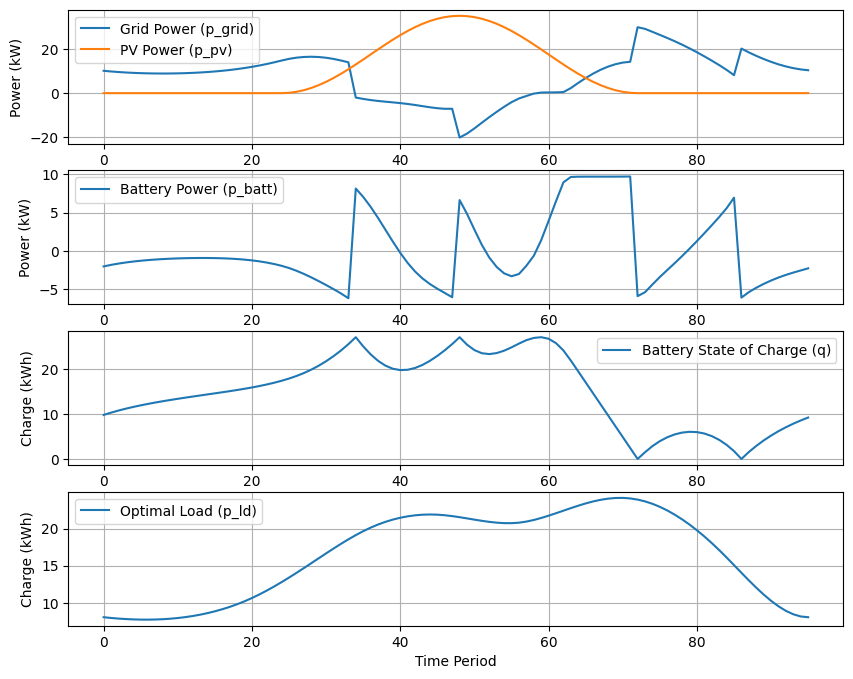

In [60]:

if p_grid_opt is not None:
    plt.figure(figsize=(10, 8))
    plt.subplot(4, 1, 1)
    plt.plot(p_grid_opt, label="Grid Power (p_grid)")
    plt.plot(p_pv, label="PV Power (p_pv)")
    plt.ylabel("Power (kW)")
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 2)
    plt.plot(p_batt_opt, label="Battery Power (p_batt)")
    plt.ylabel("Power (kW)")
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 3)
    plt.plot(q_opt, label="Battery State of Charge (q)")
    plt.xlabel("Time Period")
    plt.ylabel("Charge (kWh)")
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 4)
    plt.plot(p_ld_opt , label="Optimal Load (p_ld)")
    plt.xlabel("Time Period")
    plt.ylabel("Charge (kWh)")
    plt.legend()
    plt.grid()

    plt.show()

b)

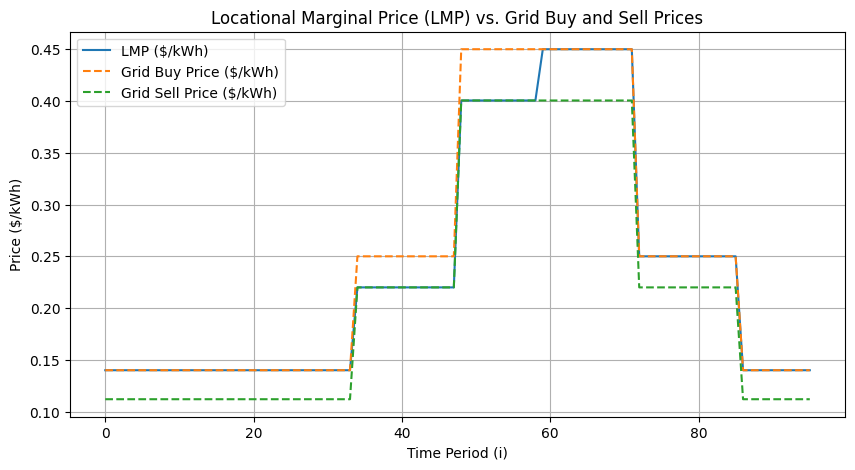

In [61]:

plt.figure(figsize=(10, 5))
plt.plot(lmp, label="LMP ($/kWh)", linestyle='-')
plt.plot(R_buy, label="Grid Buy Price ($/kWh)", linestyle='--')
plt.plot(R_sell, label="Grid Sell Price ($/kWh)", linestyle='--')
plt.xlabel("Time Period (i)")
plt.ylabel("Price ($/kWh)")
plt.title("Locational Marginal Price (LMP) vs. Grid Buy and Sell Prices")
plt.legend()
plt.grid(True)
plt.show()

lmp_comment = """
The LMP fluctuates over time and generally lies between the buy and sell prices.
This indicates that at times the microgrid pays a premium when drawing power from the grid, 
but also benefits from higher returns when selling excess power. The LMP provides a measure 
of the real-time cost of electricity at the microgrid and is influenced by both supply (solar generation, battery discharge) 
and demand (load requirements).
"""

In [62]:
lmp_comment = """
The LMP fluctuates over time and generally lies between the buy and sell prices.\n 
This indicates that at times the microgrid pays a premium when drawing power from the grid, \n
but also benefits from higher returns when selling excess power. The LMP provides a measure \n
of the real-time cost of electricity at the microgrid and is influenced by both supply (solar generation, battery discharge) \n
and demand (load requirements).
"""

In [63]:
print(lmp_comment)


The LMP fluctuates over time and generally lies between the buy and sell prices.
 
This indicates that at times the microgrid pays a premium when drawing power from the grid, 

but also benefits from higher returns when selling excess power. The LMP provides a measure 

of the real-time cost of electricity at the microgrid and is influenced by both supply (solar generation, battery discharge) 

and demand (load requirements).



c)

In [64]:
p_ld.T @ constraints[0].dual_value

np.float64(-107.58803404329691)

In [66]:
if lmp is not None:
    payment_load = np.dot(dual_vals, p_ld)
    payment_pv = np.dot(dual_vals, p_pv)
    payment_batt = np.dot(dual_vals, p_batt_opt) 
    payment_grid = np.dot(dual_vals, p_grid_opt) 

    payments = {
        "Load Payment ($)": payment_load,
        "PV Payment ($)": payment_pv,
        "Battery Payment ($)": payment_batt,
        "Grid Payment ($)": payment_grid,
        "Balance Check ($)": payment_load - (payment_pv + (payment_batt if payment_batt is not None else 0) + (payment_grid if payment_grid is not None else 0))
    }

    df_payments = pd.DataFrame(payments, index=["LMP Payments"]).T


In [67]:
df_payments

,LMP Payments
Load Payment ($),107.588034
PV Payment ($),66.450709
Battery Payment ($),8.370000
Grid Payment ($),32.767325
Balance Check ($),0.000000
